# Particle Swarm Optimization


# Import and Setup

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

# Create plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Random seed for reproducibility
np.random.seed(42)

# Creates folders for outputs
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Setup complete!")
print(f"NumPy version: {np.__version__}")

Setup complete!
NumPy version: 1.26.3


In [27]:
# Base class for test functions
# This way we don't repeat code for each function

class TestFunction:
    def __init__(self, name, bounds_lower, bounds_upper):
        self.name = name
        self.bounds_lower = bounds_lower
        self.bounds_upper = bounds_upper
        self.n_evaluations = 0  # keep track of how many times we call the function
    
    def evaluate(self, x):
        # Each specific function will implement this
        raise NotImplementedError("Need to implement this in subclass")
    
    def __call__(self, x):
        # This lets us call the function like func(x) instead of func.evaluate(x)
        return self.evaluate(x)
    
    def reset_counter(self):
        self.n_evaluations = 0

print("Base class ready")

Base class ready


# Sphere Function

In [ ]:
class SphereFunction(TestFunction):
    """Sphere function"""
    def __init__(self):
        super().__init__("Sphere", -5.12, 5.12)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        return np.sum(x ** 2)


class RosenbrockFunction(TestFunction):
    """Rosenbrock benchmark function"""
    def __init__(self):
        super().__init__("Rosenbrock", -5.0, 10.0)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)


class RastriginFunction(TestFunction):
    """Rastrigin"""
    def __init__(self):
        super().__init__("Rastrigin", -5.12, 5.12)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        n = len(x)
        return 10 * n + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))


class AckleyFunction(TestFunction):
    """Ackley function"""
    def __init__(self):
        super().__init__("Ackley", -32.768, 32.768)
    
    def evaluate(self, x):
        self.n_evaluations += 1
        n = len(x)
        sum_sq = np.sum(x ** 2)
        sum_cos = np.sum(np.cos(2 * np.pi * x))
        term1 = -20 * np.exp(-0.2 * np.sqrt(sum_sq / n))
        term2 = -np.exp(sum_cos / n)
        return term1 + term2 + 20 + np.e


def get_function(name):
    """Get test function by name"""
    functions = {
        'sphere': SphereFunction(),
        'rosenbrock': RosenbrockFunction(),
        'rastrigin': RastriginFunction(),
        'ackley': AckleyFunction()
    }
    if name.lower() not in functions:
        raise ValueError(f"Unknown function: {name}")
    return functions[name.lower()]


# Quick validation
print("Test Functions Implemented:")
print("-" * 60)
for name in ['sphere', 'rosenbrock', 'rastrigin', 'ackley']:
    func = get_function(name)
    val = func(np.zeros(5))
    print(f"{func.name:12s}: f(0,0,0,0,0) = {val:10.6f}")
print("-" * 60)
print("All functions ready!")

Test Functions Implemented:
------------------------------------------------------------
Sphere      : f(0,0,0,0,0) =   0.000000
Rosenbrock  : f(0,0,0,0,0) =   4.000000
Rastrigin   : f(0,0,0,0,0) =   0.000000
Ackley      : f(0,0,0,0,0) =   0.000000
------------------------------------------------------------
All functions ready!


# Particle Swarm Optimization Algorithm

In [34]:
# Particle Swarm Optimization Algorithm
# v = w*v + c1*r1*(pbest-x) + c2*r2*(gbest-x)

class Particle:
    """Single particle in the swarm"""
    def __init__(self, dimensions, bounds_lower, bounds_upper):
        self.position = np.random.uniform(bounds_lower, bounds_upper, dimensions)
        range_size = bounds_upper - bounds_lower
        self.velocity = np.random.uniform(-0.15 * range_size, 0.15 * range_size, dimensions)
        self.pbest_position = self.position.copy()
        self.pbest_fitness = float('inf')
        self.fitness = float('inf')


class PSO:
    """
    Particle Swarm Optimization
    
    Parameters (following Lecture 5):
    - w: inertia weight (0.7 - improved PSO)
    - c1: cognitive coefficient (1.5 - within range 0-4)
    - c2: social coefficient (1.5 - within range 0-4)
    - c1 + c2 = 3.0 (satisfies constraint <= 4)
    """
    
    def __init__(self, n_particles=30, max_iterations=300, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.max_iterations = max_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = []
        self.gbest_position = None
        self.gbest_fitness = float('inf')
        self.convergence_curve = []
    
    def initialize_swarm(self, dimensions, bounds_lower, bounds_upper):
        """Create swarm of particles"""
        self.particles = [Particle(dimensions, bounds_lower, bounds_upper) 
                         for _ in range(self.n_particles)]
        self.gbest_position = None
        self.gbest_fitness = float('inf')
        self.convergence_curve = []
    
    def evaluate_swarm(self, objective_function):
        """Evaluate all particles and update bests"""
        for particle in self.particles:
            particle.fitness = objective_function(particle.position)
            
            if particle.fitness < particle.pbest_fitness:
                particle.pbest_fitness = particle.fitness
                particle.pbest_position = particle.position.copy()
            
            if particle.fitness < self.gbest_fitness:
                self.gbest_fitness = particle.fitness
                self.gbest_position = particle.position.copy()
    
    def update_velocity(self, particle, bounds_lower, bounds_upper):
        """Update velocity using PSO formula"""
        r1 = np.random.random(len(particle.position))
        r2 = np.random.random(len(particle.position))
        
        cognitive = self.c1 * r1 * (particle.pbest_position - particle.position)
        social = self.c2 * r2 * (self.gbest_position - particle.position)
        
        particle.velocity = self.w * particle.velocity + cognitive + social
        
        # Velocity clamping
        v_max = 0.2 * (bounds_upper - bounds_lower)
        particle.velocity = np.clip(particle.velocity, -v_max, v_max)
    
    def update_position(self, particle, bounds_lower, bounds_upper):
        """Update position and enforce bounds"""
        particle.position = particle.position + particle.velocity
        particle.position = np.clip(particle.position, bounds_lower, bounds_upper)
    
    def optimize(self, objective_function, dimensions, bounds_lower, bounds_upper, verbose=True):
        """Run PSO optimization"""
        if verbose:
            print(f"PSO: {self.n_particles} particles, {self.max_iterations} iterations")
            print(f"Parameters: w={self.w}, c1={self.c1}, c2={self.c2}\n")
        
        self.initialize_swarm(dimensions, bounds_lower, bounds_upper)
        self.evaluate_swarm(objective_function)
        self.convergence_curve = [self.gbest_fitness]
        
        if verbose:
            print(f"Initial: {self.gbest_fitness:.6e}")
        
        for iteration in range(self.max_iterations):
            for particle in self.particles:
                self.update_velocity(particle, bounds_lower, bounds_upper)
                self.update_position(particle, bounds_lower, bounds_upper)
            
            self.evaluate_swarm(objective_function)
            self.convergence_curve.append(self.gbest_fitness)
            
            if verbose and (iteration + 1) % 50 == 0:
                print(f"Iter {iteration+1}: {self.gbest_fitness:.6e}")
            
            if self.gbest_fitness < 1e-10:
                if verbose:
                    print(f"Converged at iteration {iteration+1}")
                break
        
        if verbose:
            print(f"\nFinal: {self.gbest_fitness:.6e}")
        
        return self.gbest_position, self.gbest_fitness, self.convergence_curve


print("PSO Algorithm ready!")

PSO Algorithm ready!


# Test PSO on Sphere

In [ ]:
# Test PSO on Sphere function
print("=" * 70)
print("TESTING PSO ON SPHERE FUNCTION (5D)")
print("=" * 70)

sphere = SphereFunction()
pso = PSO(n_particles=20, max_iterations=100)

best_pos, best_fit, curve = pso.optimize(
    sphere.evaluate, 5, sphere.bounds_lower, sphere.bounds_upper
)

print(f"\nResults:")
print(f"  Best fitness: {best_fit:.6e}")
print(f"  Best position: {best_pos}")
print(f"  Success: {'YES' if best_fit < 1e-6 else 'NO'}")
print("=" * 70)

TESTING PSO ON SPHERE FUNCTION (5D)
PSO: 20 particles, 100 iterations
Parameters: w=0.7, c1=1.5, c2=1.5

Initial: 2.154494e+01
Iter 50: 3.495397e-05
Iter 100: 5.658789e-09

Final: 5.658789e-09

Results:
  Best fitness: 5.658789e-09
  Best position: [-3.86312876e-05 -4.61041080e-05 -3.63359517e-05  1.97437122e-05
  1.81853840e-05]
  Success: YES ✓


# Test all and Visualize

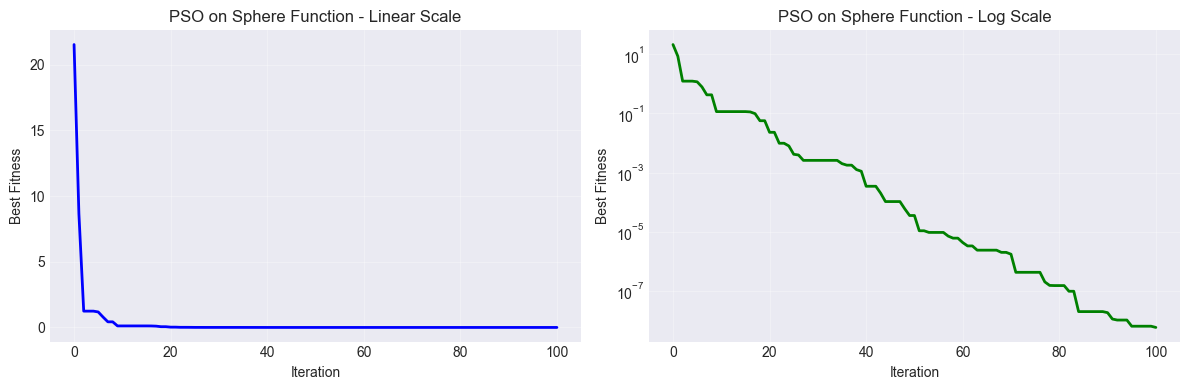


TESTING ALL BENCHMARK FUNCTIONS (10D)
Sphere      : 9.194740e-11
Rosenbrock  : 5.434191e+00
Rastrigin   : 5.009089e+00
Ackley      : 1.640702e-05

All functions tested successfully!


In [36]:
# Visualization and comprehensive testing

def plot_convergence(curve, title):
    """Plot convergence curve"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(curve, 'b-', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best Fitness')
    ax1.set_title(f'{title} - Linear Scale')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(curve, 'g-', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Best Fitness')
    ax2.set_title(f'{title} - Log Scale')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot Sphere convergence
plot_convergence(curve, "PSO on Sphere Function")

# Test all functions
print("\n" + "=" * 70)
print("TESTING ALL BENCHMARK FUNCTIONS (10D)")
print("=" * 70)

results = []
for func_name in ['sphere', 'rosenbrock', 'rastrigin', 'ackley']:
    func = get_function(func_name)
    pso = PSO(n_particles=30, max_iterations=200)
    
    best_pos, best_fit, curve = pso.optimize(
        func.evaluate, 10, func.bounds_lower, func.bounds_upper, verbose=False
    )
    
    results.append({'Function': func.name, 'Final Fitness': best_fit})
    print(f"{func.name:12s}: {best_fit:.6e}")

print("=" * 70)
print("\nAll functions tested successfully!")

# Multiple Runs Framework

In [37]:
# Multiple Runs Framework for Statistical Analysis

def run_multiple_trials(func_name, dimensions, n_runs=30, verbose=True):
    """
    Run PSO multiple times on a function and collect statistics
    
    Args:
        func_name: Name of test function
        dimensions: Problem dimensionality
        n_runs: Number of independent runs
        verbose: Print progress
    
    Returns:
        Dictionary with results and statistics
    """
    func = get_function(func_name)
    
    # Adjust particle count for dimension
    if dimensions >= 30:
        n_particles = 50
    elif dimensions >= 10:
        n_particles = 30
    else:
        n_particles = 20
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"Running: {func.name.upper()} (n={dimensions}, {n_runs} trials)")
        print(f"{'='*70}")
    
    # Storage for results
    final_fitness = []
    convergence_curves = []
    n_iterations = []
    
    # Run multiple trials
    for run in range(n_runs):
        # Different seed for each run
        np.random.seed(42 + run)
        
        pso = PSO(n_particles=n_particles, max_iterations=300, w=0.7, c1=1.5, c2=1.5)
        
        best_pos, best_fit, curve = pso.optimize(
            objective_function=func.evaluate,
            dimensions=dimensions,
            bounds_lower=func.bounds_lower,
            bounds_upper=func.bounds_upper,
            verbose=False
        )
        
        final_fitness.append(best_fit)
        convergence_curves.append(curve)
        n_iterations.append(len(curve) - 1)
        
        if verbose and (run + 1) % 10 == 0:
            print(f"  Completed {run + 1}/{n_runs} runs...")
    
    # Compute statistics
    fitness_array = np.array(final_fitness)
    stats = {
        'mean': np.mean(fitness_array),
        'median': np.median(fitness_array),
        'std': np.std(fitness_array),
        'min': np.min(fitness_array),
        'max': np.max(fitness_array),
        'q25': np.percentile(fitness_array, 25),
        'q75': np.percentile(fitness_array, 75)
    }
    
    # Success rate (different thresholds per function)
    thresholds = {
        'sphere': 1e-6,
        'rosenbrock': 1e-2,
        'rastrigin': 1e-2,
        'ackley': 1e-2
    }
    threshold = thresholds.get(func_name.lower(), 1e-6)
    success_count = sum(1 for f in final_fitness if f < threshold)
    success_rate = success_count / n_runs
    
    if verbose:
        print(f"\nStatistics:")
        print(f"  Mean:   {stats['mean']:.6e}")
        print(f"  Median: {stats['median']:.6e}")
        print(f"  Std:    {stats['std']:.6e}")
        print(f"  Best:   {stats['min']:.6e}")
        print(f"  Worst:  {stats['max']:.6e}")
        print(f"  Success Rate: {success_rate*100:.1f}% (< {threshold:.0e})")
    
    return {
        'function': func_name,
        'dimension': dimensions,
        'n_runs': n_runs,
        'final_fitness': final_fitness,
        'convergence_curves': convergence_curves,
        'n_iterations': n_iterations,
        'statistics': stats,
        'success_rate': success_rate
    }


# Quick test on Sphere
print("Testing multiple runs framework:")
test_result = run_multiple_trials('sphere', dimensions=10, n_runs=5, verbose=True)

Testing multiple runs framework:

Running: SPHERE (n=10, 5 trials)

Statistics:
  Mean:   8.355704e-11
  Median: 7.985309e-11
  Std:    5.204301e-12
  Best:   7.837158e-11
  Worst:  9.060229e-11
  Success Rate: 100.0% (< 1e-06)


# Experimental Setup

In [38]:
# Full Experimental Setup
# Run 30 trials × 4 functions × 3 dimensions = 360 total experiments

# Configuration
FUNCTIONS = ['sphere', 'rosenbrock', 'rastrigin', 'ackley']
DIMENSIONS = [2, 10, 30]
N_RUNS = 30

print("\n" + "="*70)
print("STARTING FULL PSO BENCHMARK EXPERIMENTS")
print("="*70)
print(f"Functions: {len(FUNCTIONS)}")
print(f"Dimensions: {DIMENSIONS}")
print(f"Runs per config: {N_RUNS}")
print(f"Total experiments: {len(FUNCTIONS) * len(DIMENSIONS) * N_RUNS}")
print("="*70)

import time
start_time = time.time()

# Storage for all results
all_results = {}

# Run experiments
for func_name in FUNCTIONS:
    for dim in DIMENSIONS:
        key = f"{func_name}_n{dim}"
        
        # Run multiple trials
        results = run_multiple_trials(func_name, dim, N_RUNS, verbose=True)
        
        # Store results
        all_results[key] = results

elapsed_time = time.time() - start_time

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETE!")
print("="*70)
print(f"Total time: {elapsed_time/60:.2f} minutes")
print(f"Results collected for {len(all_results)} configurations")
print("="*70)


STARTING FULL PSO BENCHMARK EXPERIMENTS
Functions: 4
Dimensions: [2, 10, 30]
Runs per config: 30
Total experiments: 360

Running: SPHERE (n=2, 30 trials)
  Completed 10/30 runs...
  Completed 20/30 runs...
  Completed 30/30 runs...

Statistics:
  Mean:   5.529407e-11
  Median: 6.332430e-11
  Std:    2.883585e-11
  Best:   1.526407e-12
  Worst:  9.437088e-11
  Success Rate: 100.0% (< 1e-06)

Running: SPHERE (n=10, 30 trials)
  Completed 10/30 runs...
  Completed 20/30 runs...
  Completed 30/30 runs...

Statistics:
  Mean:   8.223756e-11
  Median: 8.499862e-11
  Std:    1.488566e-11
  Best:   2.651212e-11
  Worst:  9.985897e-11
  Success Rate: 100.0% (< 1e-06)

Running: SPHERE (n=30, 30 trials)
  Completed 10/30 runs...
  Completed 20/30 runs...
  Completed 30/30 runs...

Statistics:
  Mean:   1.671183e-06
  Median: 6.034319e-07
  Std:    3.540255e-06
  Best:   5.204254e-08
  Worst:  1.915687e-05
  Success Rate: 66.7% (< 1e-06)

Running: ROSENBROCK (n=2, 30 trials)
  Completed 10/30 run

# Comprehensive Visualization


GENERATING VISUALIZATIONS

Sphere:


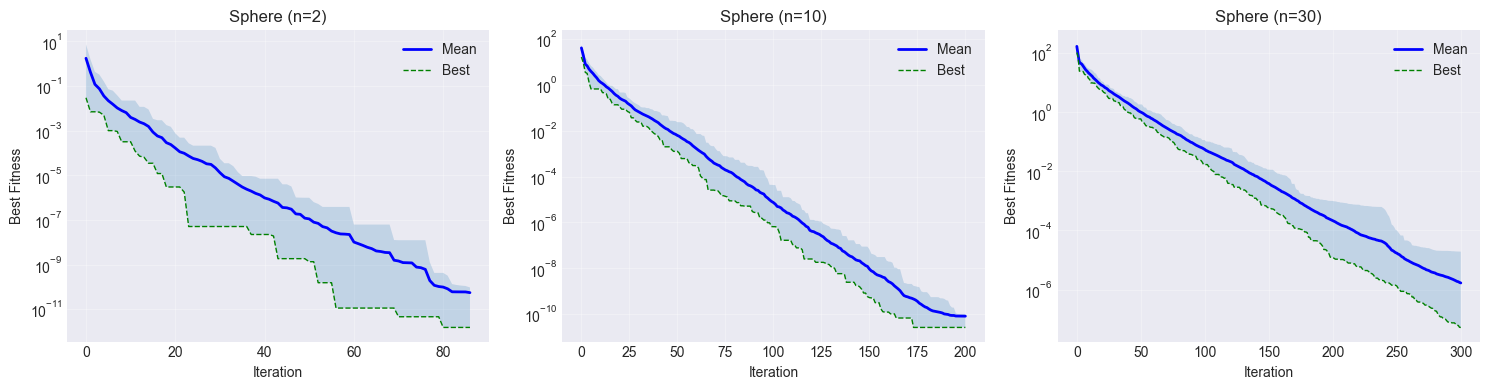

Saved plots/sphere_convergence_comparison.png


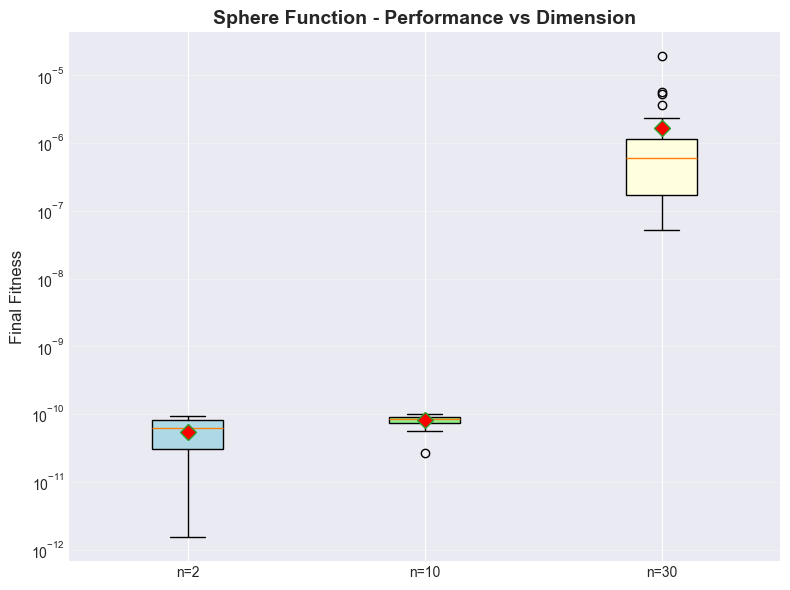

Saved plots/sphere_boxplot.png

Rosenbrock:


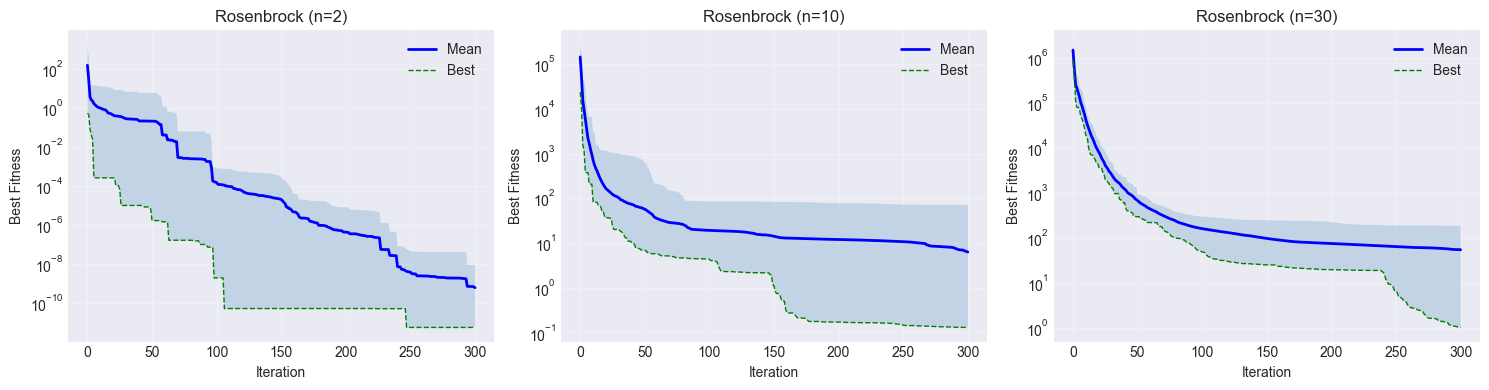

Saved plots/rosenbrock_convergence_comparison.png


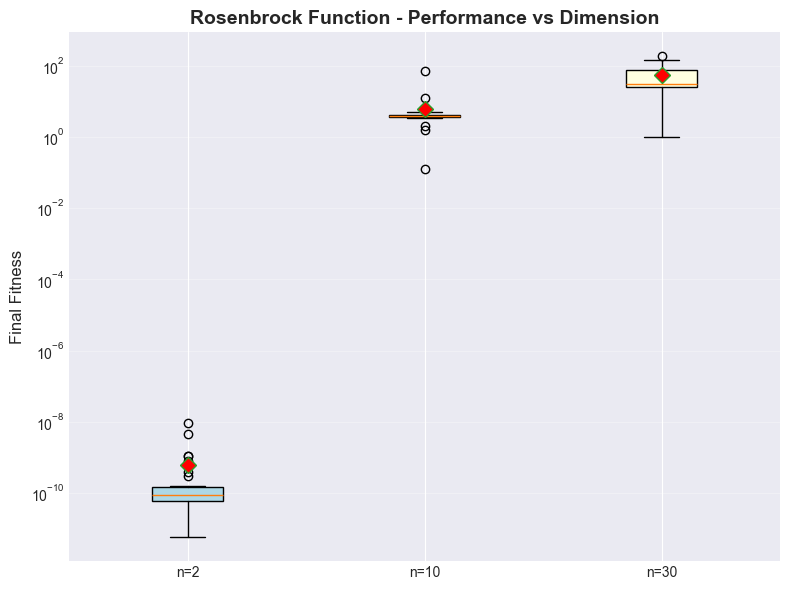

Saved plots/rosenbrock_boxplot.png

Rastrigin:


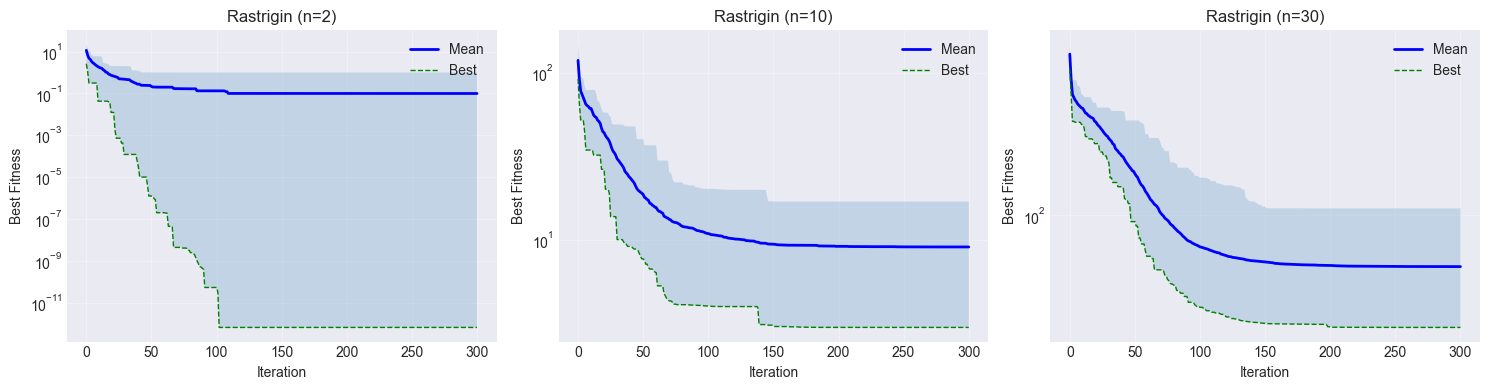

Saved plots/rastrigin_convergence_comparison.png


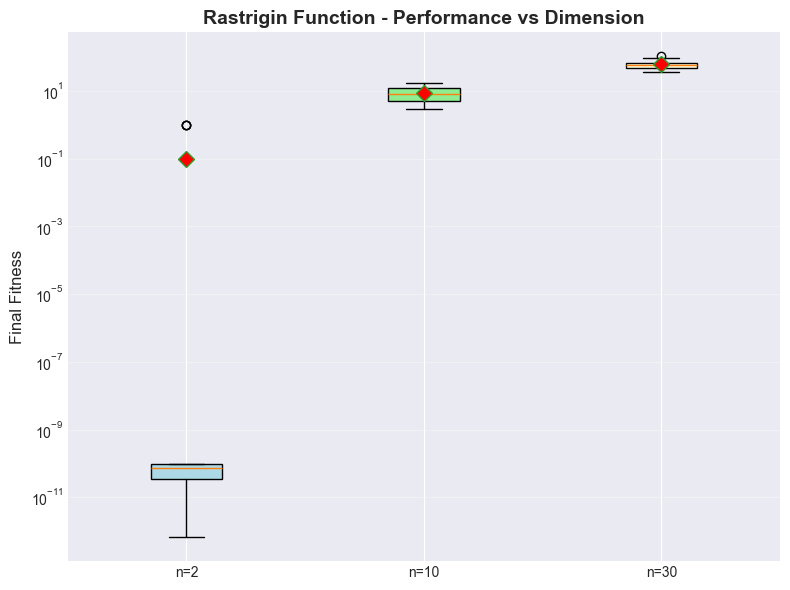

Saved plots/rastrigin_boxplot.png

Ackley:


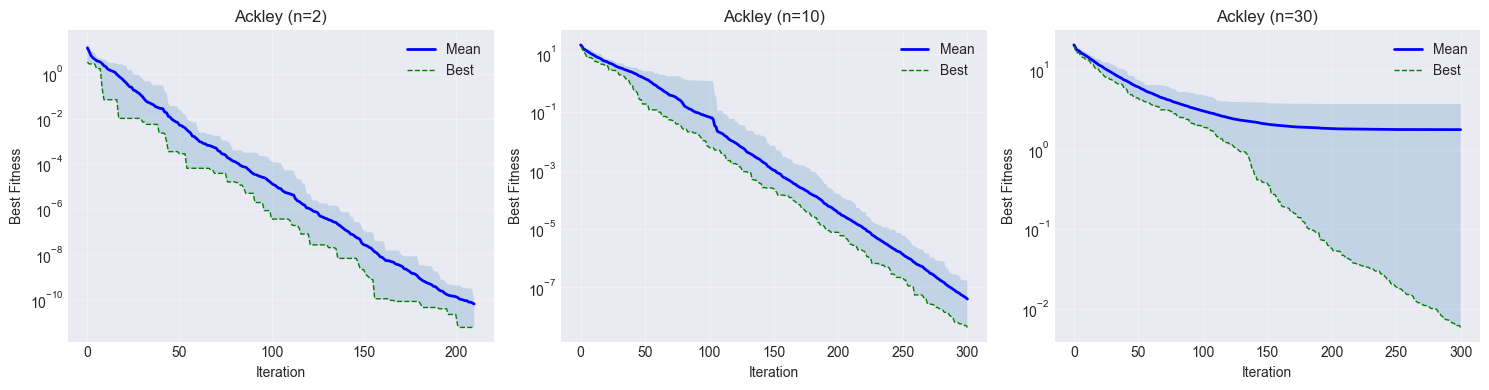

Saved plots/ackley_convergence_comparison.png


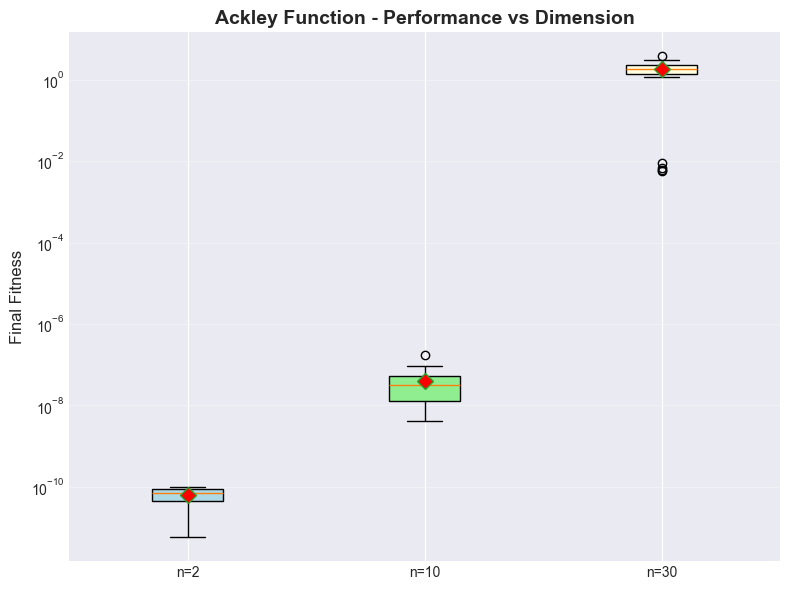

Saved plots/ackley_boxplot.png

All functions at n=10:


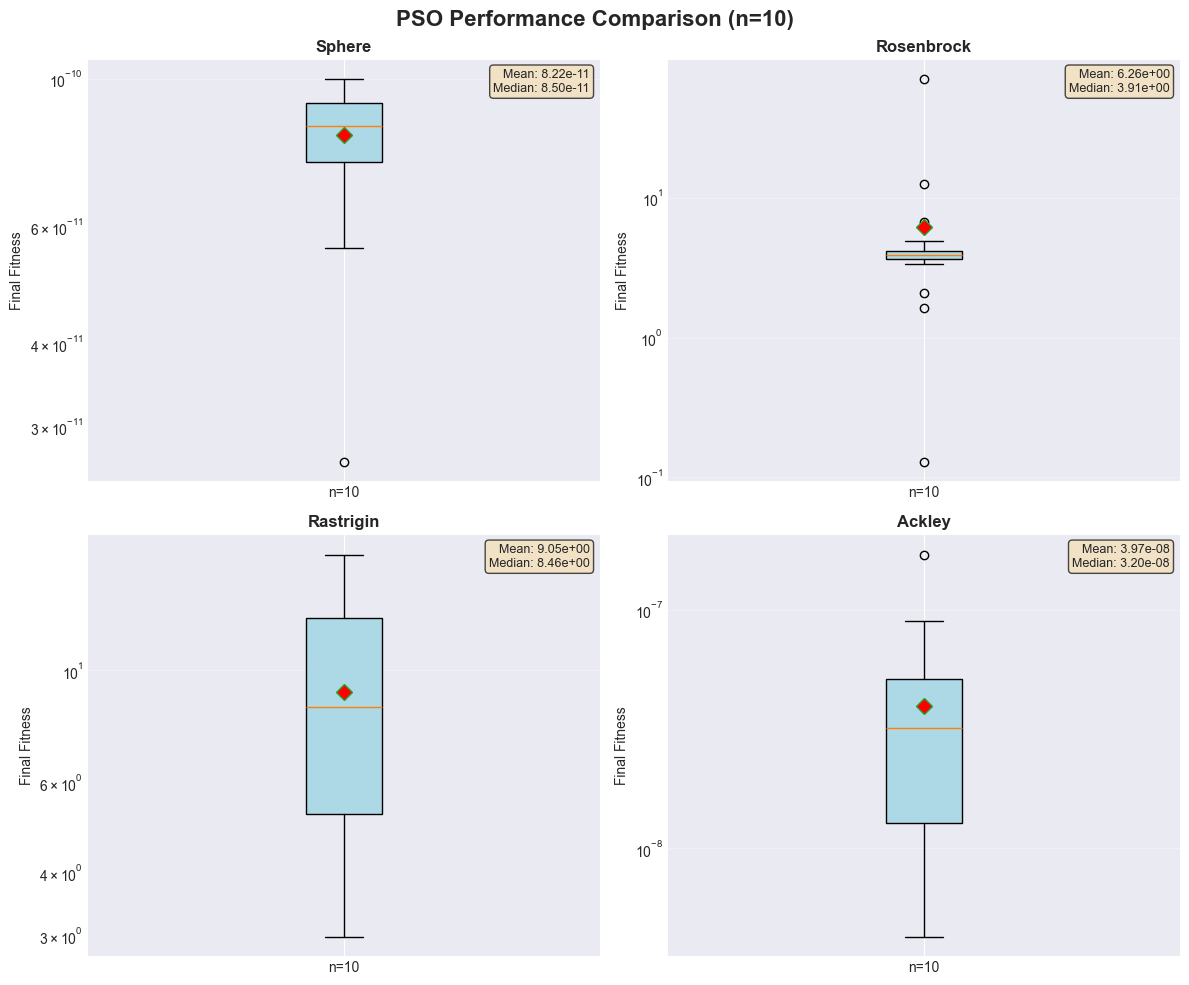

Saved plots/all_functions_n10.png

All functions at n=30:


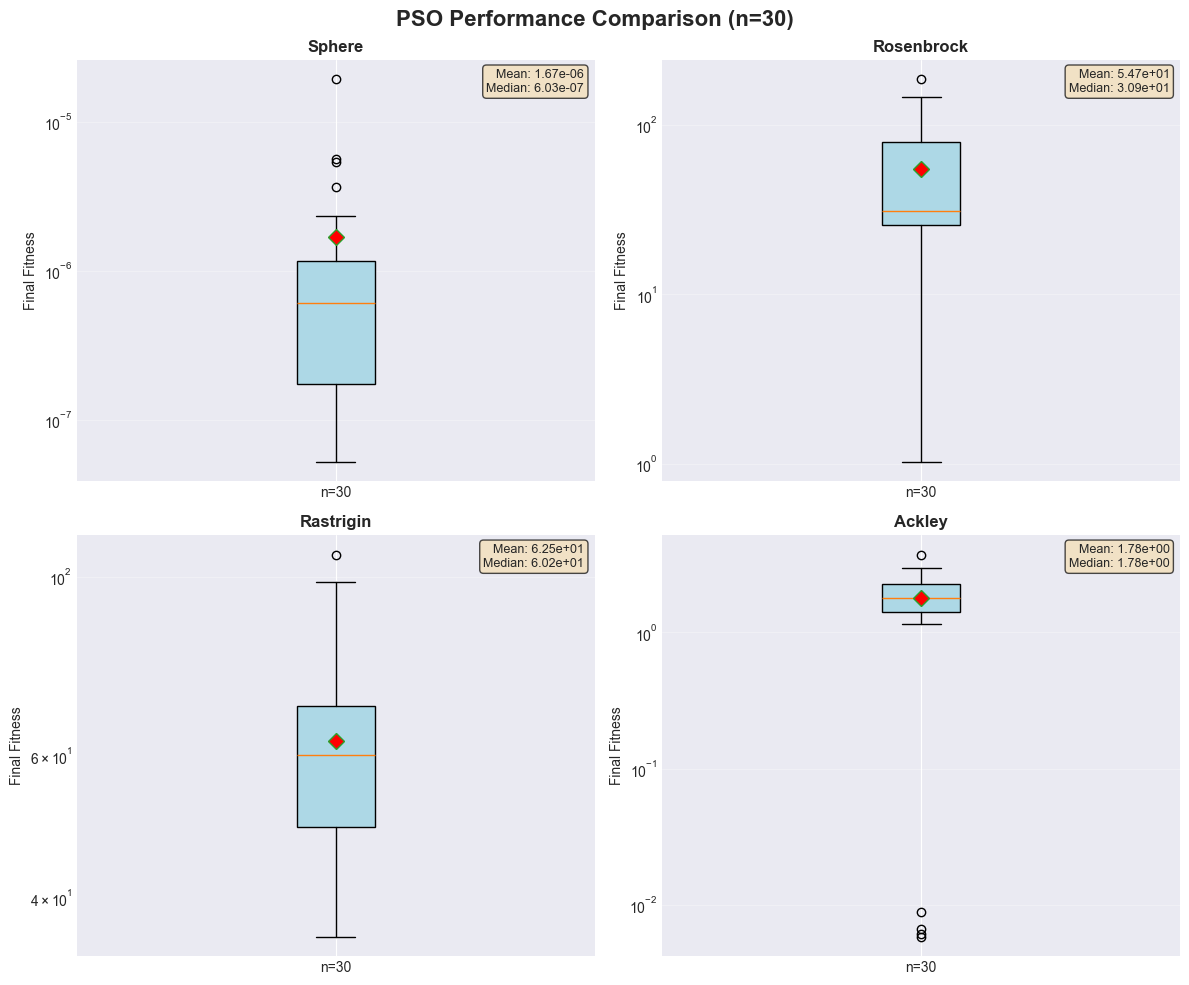

Saved plots/all_functions_n30.png

✓ All visualizations complete!


In [41]:
# Comprehensive Results Visualization

def pad_curves(curves):
    """Pad convergence curves to same length"""
    max_len = max(len(curve) for curve in curves)
    padded = []
    for curve in curves:
        if len(curve) < max_len:
            # Pad with last value (fitness stays same after convergence)
            padded_curve = curve + [curve[-1]] * (max_len - len(curve))
        else:
            padded_curve = curve
        padded.append(padded_curve)
    return np.array(padded)


def plot_convergence_comparison(results_dict, func_name):
    """Plot convergence for different dimensions"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, dim in enumerate([2, 10, 30]):
        ax = axes[idx]
        key = f"{func_name}_n{dim}"
        
        if key in results_dict:
            curves = results_dict[key]['convergence_curves']
            
            # Pad curves to same length
            curves_array = pad_curves(curves)
            
            # Plot mean and range
            mean_curve = np.mean(curves_array, axis=0)
            min_curve = np.min(curves_array, axis=0)
            max_curve = np.max(curves_array, axis=0)
            
            iterations = np.arange(len(mean_curve))
            
            ax.plot(iterations, mean_curve, 'b-', linewidth=2, label='Mean')
            ax.plot(iterations, min_curve, 'g--', linewidth=1, label='Best')
            ax.fill_between(iterations, min_curve, max_curve, alpha=0.2)
            
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Best Fitness')
            ax.set_title(f'{func_name.capitalize()} (n={dim})')
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
            ax.legend()
    
    plt.tight_layout()
    plt.savefig(f'plots/{func_name}_convergence_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved plots/{func_name}_convergence_comparison.png")


def plot_boxplot_comparison(results_dict, func_name):
    """Create boxplot comparing dimensions"""
    data = []
    labels = []
    
    for dim in [2, 10, 30]:
        key = f"{func_name}_n{dim}"
        if key in results_dict:
            data.append(results_dict[key]['final_fitness'])
            labels.append(f'n={dim}')
    
    if not data:
        print(f"No data for {func_name}")
        return
    
    plt.figure(figsize=(8, 6))
    bp = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    # Color boxes
    colors = ['lightblue', 'lightgreen', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel('Final Fitness', fontsize=12)
    plt.title(f'{func_name.capitalize()} Function - Performance vs Dimension', 
              fontsize=14, fontweight='bold')
    plt.yscale('log')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'plots/{func_name}_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved plots/{func_name}_boxplot.png")


def plot_all_functions_comparison(results_dict, dimension):
    """Compare all functions at a specific dimension"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, func_name in enumerate(FUNCTIONS):
        ax = axes[idx]
        key = f"{func_name}_n{dimension}"
        
        if key in results_dict:
            data = results_dict[key]['final_fitness']
            stats = results_dict[key]['statistics']
            
            # Boxplot
            bp = ax.boxplot([data], patch_artist=True, showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
            bp['boxes'][0].set_facecolor('lightblue')
            
            ax.set_ylabel('Final Fitness')
            ax.set_title(f'{func_name.capitalize()}', fontweight='bold')
            ax.set_xticks([1])
            ax.set_xticklabels([f'n={dimension}'])
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add statistics text
            text = f"Mean: {stats['mean']:.2e}\nMedian: {stats['median']:.2e}"
            ax.text(0.98, 0.98, text, transform=ax.transAxes,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                   fontsize=9)
    
    plt.suptitle(f'PSO Performance Comparison (n={dimension})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'plots/all_functions_n{dimension}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved plots/all_functions_n{dimension}.png")


# Generate all visualizations
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

for func_name in FUNCTIONS:
    print(f"\n{func_name.capitalize()}:")
    plot_convergence_comparison(all_results, func_name)
    plot_boxplot_comparison(all_results, func_name)

for dim in [10, 30]:
    print(f"\nAll functions at n={dim}:")
    plot_all_functions_comparison(all_results, dim)

print("\n" + "="*70)
print("✓ All visualizations complete!")
print("="*70)

# Export Results and Summary

In [45]:
# Export Results and Summary

import json

# Create summary table
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY TABLE")
print("="*80)
print(f"{'Function':<12} {'Dim':<5} {'Mean':<12} {'Median':<12} {'Std':<12} {'Best':<12} {'Worst':<12} {'Success%':<10}")
print("="*80)

summary_data = []

for func_name in FUNCTIONS:
    for dim in DIMENSIONS:
        key = f"{func_name}_n{dim}"
        if key in all_results:
            results = all_results[key]
            stats = results['statistics']
            success_rate = results['success_rate'] * 100
            
            print(f"{func_name.capitalize():<12} {dim:<5} "
                  f"{stats['mean']:<12.4e} {stats['median']:<12.4e} "
                  f"{stats['std']:<12.4e} {stats['min']:<12.4e} "
                  f"{stats['max']:<12.4e} {success_rate:<10.1f}")
            
            summary_data.append({
                'Function': func_name.capitalize(),
                'Dimension': dim,
                'Mean': stats['mean'],
                'Median': stats['median'],
                'Std': stats['std'],
                'Min': stats['min'],
                'Max': stats['max'],
                'Success_Rate': success_rate
            })

print("="*80)

# Save to CSV
df = pd.DataFrame(summary_data)
df.to_csv('results/summary_table.csv', index=False)
print("\nSummary table saved to: results/summary_table.csv")

# Save complete results to JSON
def convert_for_json(obj):
    """Convert numpy types to native Python types"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_for_json(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(item) for item in obj]
    return obj

json_results = convert_for_json(all_results)

with open('results/complete_results.json', 'w') as f:
    json.dump(json_results, f, indent=2)

print("Complete results saved to: results/complete_results.json")

# Analysis summary
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print("\nEasy Functions (Sphere, Ackley):")
for func_name in ['sphere', 'ackley']:
    key = f"{func_name}_n10"
    if key in all_results:
        mean = all_results[key]['statistics']['mean']
        success = all_results[key]['success_rate'] * 100
        print(f"  {func_name.capitalize():12s}: Mean={mean:.2e}, Success={success:.0f}%")

print("\nModerate Function (Rosenbrock):")
key = "rosenbrock_n10"
if key in all_results:
    mean = all_results[key]['statistics']['mean']
    success = all_results[key]['success_rate'] * 100
    print(f"  Rosenbrock: Mean={mean:.2e}, Success={success:.0f}%")

print("\nHard Function (Rastrigin):")
key = "rastrigin_n10"
if key in all_results:
    mean = all_results[key]['statistics']['mean']
    success = all_results[key]['success_rate'] * 100
    print(f"  Rastrigin: Mean={mean:.2e}, Success={success:.0f}%")

print("\nDimensionality Impact (Sphere function):")
for dim in [2, 10, 30]:
    key = f"sphere_n{dim}"
    if key in all_results:
        mean = all_results[key]['statistics']['mean']
        print(f"  n={dim:2d}: {mean:.2e}")

print("\n" + "="*80)
print("="*80)
print("\nGenerated files:")
print("plots/ - All convergence and comparison plots")
print("results/summary_table.csv - Statistics table")
print("results/complete_results.json - Full results data")
print("="*80)


FINAL RESULTS SUMMARY TABLE
Function     Dim   Mean         Median       Std          Best         Worst        Success%  
Sphere       2     5.5294e-11   6.3324e-11   2.8836e-11   1.5264e-12   9.4371e-11   100.0     
Sphere       10    8.2238e-11   8.4999e-11   1.4886e-11   2.6512e-11   9.9859e-11   100.0     
Sphere       30    1.6712e-06   6.0343e-07   3.5403e-06   5.2043e-08   1.9157e-05   66.7      
Rosenbrock   2     6.2359e-10   8.4540e-11   1.7401e-09   5.6792e-12   8.8879e-09   100.0     
Rosenbrock   10    6.2580e+00   3.9148e+00   1.2122e+01   1.2908e-01   7.0713e+01   0.0       
Rosenbrock   30    5.4729e+01   3.0934e+01   4.2965e+01   1.0248e+00   1.8619e+02   0.0       
Rastrigin    2     9.9496e-02   7.4760e-11   2.9849e-01   6.6080e-13   9.9496e-01   90.0      
Rastrigin    10    9.0541e+00   8.4571e+00   4.0890e+00   2.9849e+00   1.6914e+01   0.0       
Rastrigin    30    6.2530e+01   6.0195e+01   1.7105e+01   3.5819e+01   1.0653e+02   0.0       
Ackley       2     6.